## Import packages.

In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

#rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 23
rcParams['font.weight'] = 300


## APOGEE labels.

> Restore all the labels.

In [ ]:
# restore data
from astropy.io import fits
hdulist = fits.open('../Catalog_Apogee_Payne.fits.gz')
Teff = hdulist[1].data["Teff"]
Logg = hdulist[1].data["Logg"]
FeH = hdulist[1].data["FeH"]
CH = hdulist[1].data["CH"]
NH = hdulist[1].data["NH"]
OH = hdulist[1].data["OH"]
MgH = hdulist[1].data["MgH"]


In [ ]:
# plot histogram
plt.hist(MgH, bins=100);

> Restore network and predict results.

In [3]:
# In [0]:
# import packages
import numpy as np

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

from astropy.io import fits


#========================================================================================================
# In [1]:
# import training set
# restore data
hdulist = fits.open('../Catalog_Apogee_Payne.fits.gz')

Teff = hdulist[1].data["Teff"]
Logg = hdulist[1].data["Logg"]
FeH = hdulist[1].data["FeH"]

CFe = hdulist[1].data["CH"] - hdulist[1].data["FeH"]
NFe = hdulist[1].data["NH"] - hdulist[1].data["FeH"]
OFe = hdulist[1].data["OH"] - hdulist[1].data["FeH"]
MgFe = hdulist[1].data["MgH"] - hdulist[1].data["FeH"]

MgFe = hdulist[1].data["AlH"] - hdulist[1].data["FeH"]
MgFe = hdulist[1].data["SiH"] - hdulist[1].data["FeH"]
MgFe = hdulist[1].data["SH"] - hdulist[1].data["FeH"]
MgFe = hdulist[1].data["KH"] - hdulist[1].data["FeH"]

MgFe = hdulist[1].data["CaH"] - hdulist[1].data["FeH"]
MgFe = hdulist[1].data["TiH"] - hdulist[1].data["FeH"]
MgFe = hdulist[1].data["CrH"] - hdulist[1].data["FeH"]
MgFe = hdulist[1].data["MnH"] - hdulist[1].data["FeH"]

MgFe = hdulist[1].data["NiH"] - hdulist[1].data["FeH"]
MgFe = hdulist[1].data["CuH"] - hdulist[1].data["FeH"]

# make training catalog
y_tr = np.vstack([Teff,Logg,FeH,CFe,NFe,OFe,MgFe]).T

# convert into torch
y_tr = torch.from_numpy(y_tr).type(torch.FloatTensor)

# standardize
mu_y = y_tr.mean(dim=0)
std_y = y_tr.std(dim=0)
y_tr = (y_tr - mu_y) / std_y

# input dimension
dim_in = y_tr.shape[-1]


#=======================================================================================================
# In [2]:
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
#==================================================================================
# restore models
flow = torch.load("flow_final.pt", map_location=lambda storage, loc: storage) # load in cpu
flow.eval()
print(flow.mask)

# sample results
z1 = flow.f(y_tr[::2,:])[0].detach().numpy()
x1 = y_tr[::2,:]
z2 = np.random.multivariate_normal(np.zeros(dim_in), np.eye(dim_in), x1.shape[0])
x2 = flow.sample(torch.from_numpy(z2).type(torch.FloatTensor))

# rescale the results
x1 = x1*std_y + mu_y
x2 = x2*std_y + mu_y

# convert back to numpy
x1 = x1.detach().numpy()
x2 = x2.detach().numpy()

# save results
np.savez("real_nvp_results.npz",\
         z1 = z1,\
         z2 = z2,\
         x1 = x1,\
         x2 = x2)


/Users/yting/anaconda3/lib/python3.7/site-packages/torch/serialization.py:419: UserWarning: Couldn't retrieve source code for container of type RealNVP. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/Users/yting/anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/yting/anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LeakyReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.

Parameter containing:
tensor([[1., 1., 0., 0., 0., 1., 1.],
        [0., 0., 1., 1., 1., 0., 0.],
        [1., 0., 0., 1., 1., 1., 1.],
        [0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 1., 1., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1., 1., 1.],
        [0., 1., 0., 1., 0., 0., 0.],
        [0., 1., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1., 0., 0.]])


> Plot reconstructions.

(111354, 7)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0.5, 1.0, '$X = g(z)$ [2D]')

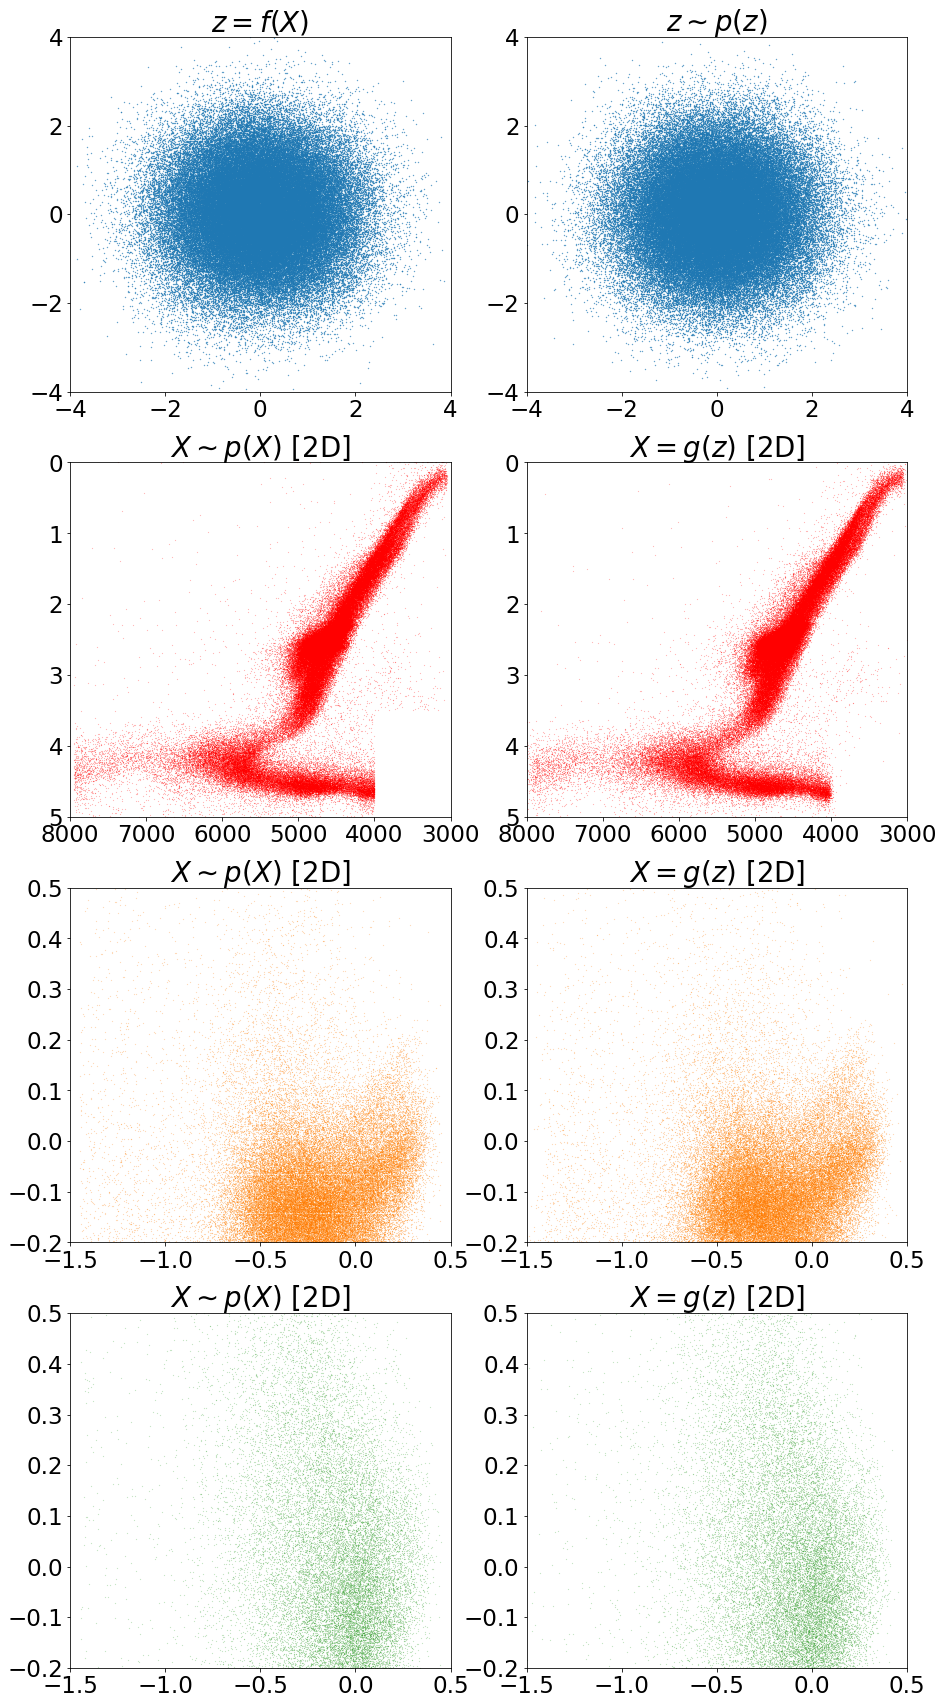

In [6]:
# setup figure
plt.figure(figsize=[15,30]);

# the latent space
temp = np.load("real_nvp_results.npz")
z = temp["z1"]
print(z.shape)
plt.subplot(421)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.scatter(z[:, 0], z[:, 1], s=0.1)
plt.title(r'$z = f(X)$')

z = temp["z2"]
plt.subplot(422)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.scatter(z[:, 0], z[:, 1], s=0.1)
plt.title(r'$z \sim p(z)$')

#-----------------------------------------------------------------------------------------
# the Kiel diagram
x = temp["x1"]
plt.subplot(423)
plt.xlim([3000,8000])
plt.ylim([0,5])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.scatter(x[:,0], x[:,1], c='r', s=0.01)
plt.title(r'$X \sim p(X)$ [2D]')

x = temp["x2"]
plt.subplot(424)
plt.xlim([3000,8000])
plt.ylim([0,5])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.scatter(x[:,0], x[:,1], c='r', s=0.01)
plt.title(r'$X = g(z)$ [2D]')

#-----------------------------------------------------------------------------------------
# Fe/H and alpha/Fe of giants
x = temp["x1"]
choose = x[:,1] < 4.
plt.subplot(425)
plt.xlim([-1.5,0.5])
plt.ylim([-0.2,0.5])
plt.scatter(x[choose,2], x[choose,6], c=cb2[1], s=0.01)
plt.title(r'$X \sim p(X)$ [2D]')

x = temp["x2"]
choose = x[:,1] < 4.
plt.subplot(426)
plt.xlim([-1.5,0.5])
plt.ylim([-0.2,0.5])
plt.scatter(x[choose,2], x[choose,6], c=cb2[1], s=0.01)
plt.title(r'$X = g(z)$ [2D]')

#-----------------------------------------------------------------------------------------
# Fe/H and alpha/Fe of giants
x = temp["x1"]
choose = x[:,1] > 4.
plt.subplot(427)
plt.xlim([-1.5,0.5])
plt.ylim([-0.2,0.5])
plt.scatter(x[choose,2], x[choose,6], c=cb2[2], s=0.01)
plt.title(r'$X \sim p(X)$ [2D]')

x = temp["x2"]
choose = x[:,1] > 4.
plt.subplot(428)
plt.xlim([-1.5,0.5])
plt.ylim([-0.2,0.5])
plt.scatter(x[choose,2], x[choose,6], c=cb2[2], s=0.01)
plt.title(r'$X = g(z)$ [2D]')


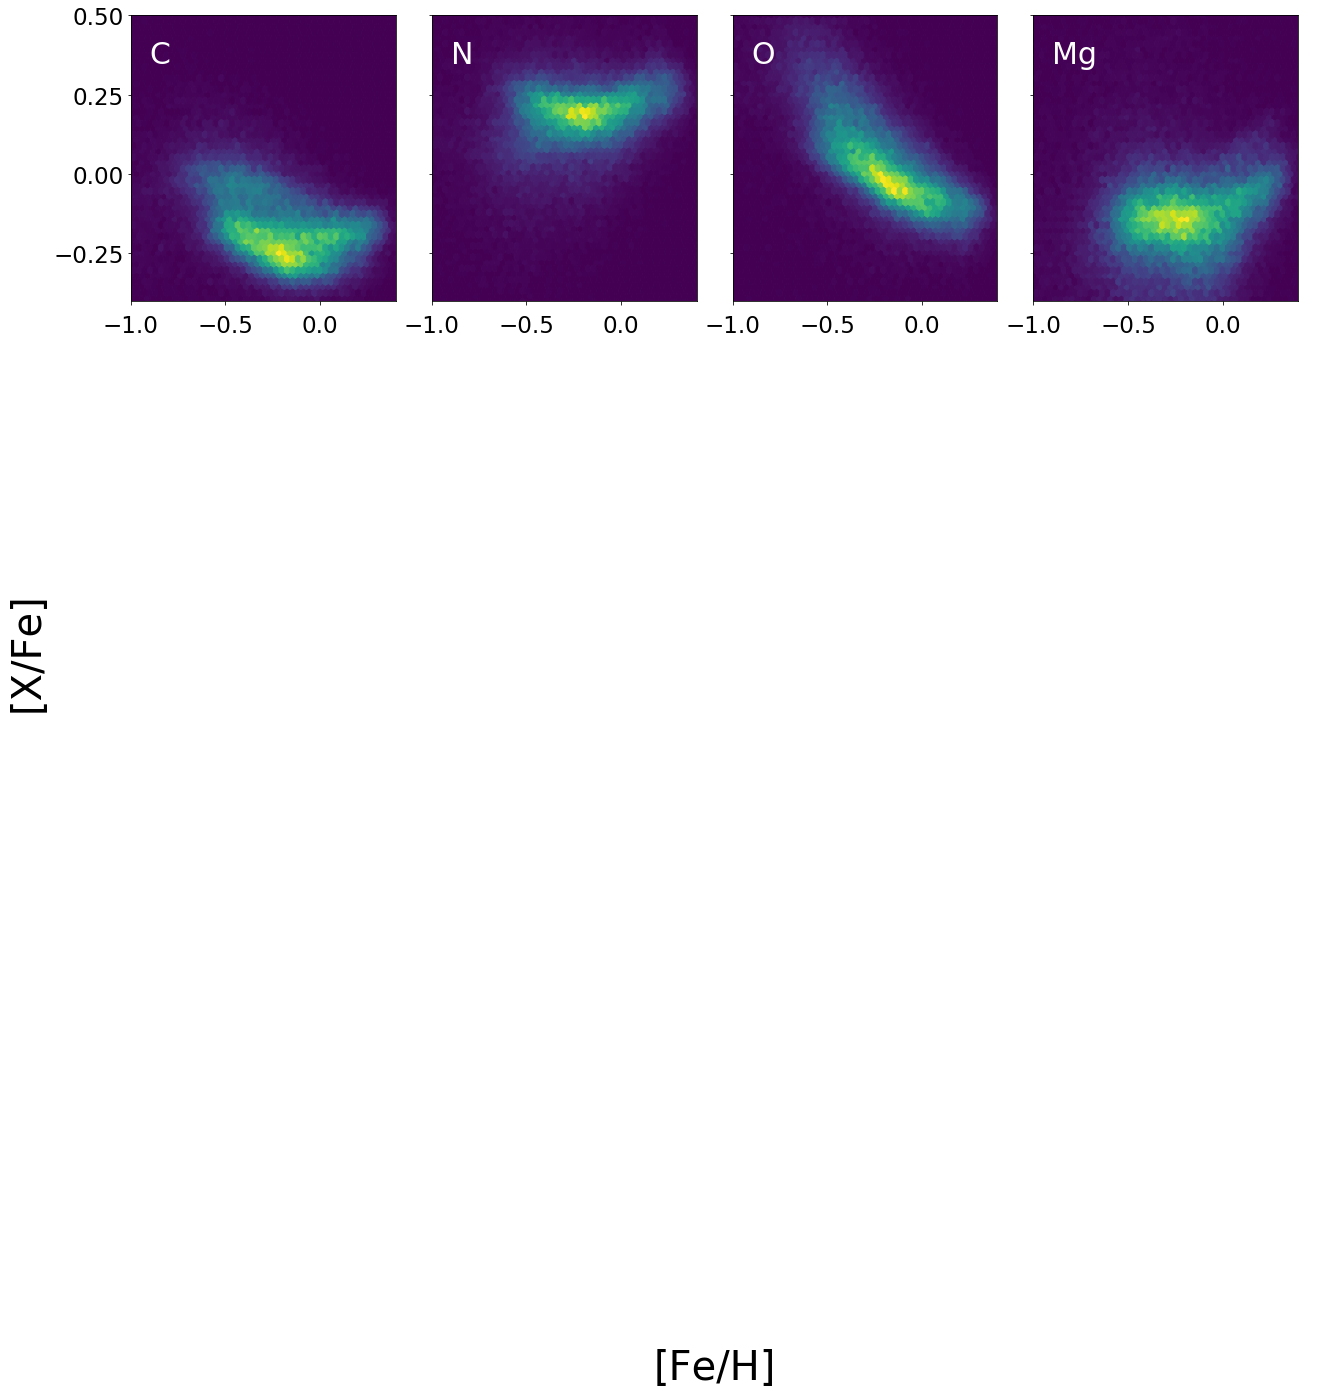

In [7]:
# import package 
import seaborn as sns
    
# reset line width
rcParams['lines.linewidth'] = 3

            
#=====================================================================================
# restore stellar labels
# real APOGEE-Payne labels
temp = np.load("real_nvp_results.npz")
x = temp["x1"]

# reconstruction from real NVP
#x = temp["x2"]


#=====================================================================================
# initiate the plot
fig = plt.figure(figsize=[20,20]);

# combine labels
ax = fig.add_subplot(111)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# axis labels
ax.set_xlabel("[Fe/H]", fontsize=40, labelpad=30);
ax.set_ylabel("[X/Fe]", fontsize=40, labelpad=40);

#----------------------------------------------------------------------------------
# label name
label_name = ["C", "N", "O", "Mg"]

#----------------------------------------------------------------------------------
# loop over all labels
for u1 in range(len(label_name)):

    # choose subplot
    ax = fig.add_subplot(4, 4, u1+1)
    
    # tick padding
    ax.tick_params(axis='x', pad=10);
    
    # plotting range
    plt.xlim([-1,0.4])
    plt.ylim([-0.4,0.5])
    plt.text(-0.9, 0.35, label_name[u1], color="white", fontsize=30)
        
    # reduce number of ticks
    plt.locator_params(nbins=4)

    # delete ticks
    if u1 % 4 != 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    if u1 < len(label_name) - 4:
        plt.setp(ax.get_xticklabels(), visible=False)
        
#----------------------------------------------------------------------------------        
    # plot results
    choose = (x[:,1] < 4)*(x[:,2] > -1.)*(np.abs(x[:,u1+3]) < 0.5)
    plt.hexbin(x[:,2][choose], x[:,u1+3][choose],\
               gridsize=50, cmap="viridis")
    
#----------------------------------------------------------------------------------  
    # add text
    #if u1 == len(label_name) - 1:
    #    plt.text(1., -0.1, "Giants\n" + r"$\mathregular{(\log\, g < 4)}$", fontsize=40)

                        
#===================================================================================
# save figure
plt.tight_layout(w_pad=0.2,h_pad=0.3)

# save figure
plt.savefig("Real.png")
#plt.savefig("Reconstruction.png")
